# REI 603M - Assignment 3

### Andri Freyr Viðarsson

In this notebook a base model for a fake news classification problem is constructed. Most of the notebook is focused on text processing and feature engineering. The data is available on https://www.kaggle.com/c/fake-news/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('fake-news/train.csv') # test.csv is not labelled
df.shape

(20800, 5)

In [3]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
df.dropna(inplace = True)
print(df.shape)

(18285, 5)


## Text pre-processing
In the follwing chunks the raw text data is processed by removing stopwords and by applying a stemming algorithm on the text.

In [5]:
df['text'].replace('\n', ' ', regex = True, inplace = True)
df["text"] = df['text'].str.replace('[^\w\s]','')

In [6]:
nltk.download('stopwords')
stopwords_ = set(stopwords.words('english'))
print(len(stopwords_))
stopwords_short = set()
for word in stopwords_:
    word_short = re.sub(
        '[^\w\s]',
        '',
        word
    )
    if word != word_short and word_short not in stopwords_short:
        stopwords_short.add(word_short)
stopwords_ = stopwords_.union(stopwords_short)
print(len(stopwords_))
    
'didnt' in stopwords_

179
204


[nltk_data] Downloading package stopwords to C:\Users\Andri
[nltk_data]     Freyr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# compare number of stopwords for fake and real articles
def n_stopwords(text):
    cnt = 0
    for word in text.split():
        if word in stopwords_: # O(1) lookup
            cnt+=1
    return cnt
df= df.assign(
        n_stop = lambda data: data['text'].map(lambda words: n_stopwords(words))
)
df

,id,title,author,text,label,n_stop
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide We Didnt Even See Comeys Letter...,1,342
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,301
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,Why the Truth Might Get You Fired October 29 2...,1,513
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,214
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print An Iranian woman has been sentenced to ...,1,58
...,...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T I unloaded on black celebrities who m...,0,106
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0,458
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macys of today grew from the union of seve...,0,306
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,NATO Russia To Hold Parallel Exercises In Balk...,1,84


In [8]:
n_stopwords_fake = df.loc[df['label'] == 1]['n_stop']
n_stopwords_real = df.loc[df['label'] == 0]['n_stop']

In [9]:
def get_percentiles(ls, perc):
    # params:
    # ls: list of numeric values
    # perc: list of percentiles
    return [np.percentile(ls, i) for i in perc]
percs = [1, 5, 25, 50, 75, 95, 99]
print(percs)
print(get_percentiles(n_stopwords_fake, percs))
print(get_percentiles(n_stopwords_real, percs))

[1, 5, 25, 50, 75, 95, 99]
[0.0, 5.150000000000034, 64.0, 159.5, 340.0, 857.8499999999995, 1705.3999999999905]
[28.0, 61.0, 152.0, 297.0, 460.0, 712.0, 1455.199999999999]


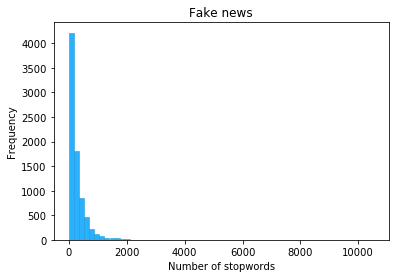

In [10]:
plt.hist(n_stopwords_fake, bins = 60,facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.xlabel('Number of stopwords')
plt.ylabel('Frequency')
plt.title('Fake news')
plt.show()

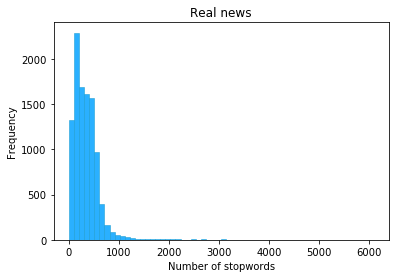

In [11]:
plt.hist(n_stopwords_real, bins = 60,facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.xlabel('Number of stopwords')
plt.ylabel('Frequency')
plt.title('Real news')
plt.show()

## Stemming
Stemming is the process of reducing words to their word stem. In the following chunks a new column is added to the dataset. That columns contains the articles after stopwords have been removed and the words have been stemmed using the Porter2 algorithm,https://www.nltk.org/howto/stem.html .

In [12]:
snow_stemmer = SnowballStemmer(language='english')
snow_stemmer.stem('waiting') # an example of how it works

'wait'

In [13]:
def stem_and_remove_stops(text):
    text_lower = text.lower()
    text_ls = text_lower.split()
    ls_removed = [snow_stemmer.stem(word) for word in text_ls if word not in stopwords_]
    return ' '.join(ls_removed)
stem_and_remove_stops(df['text'][0])[:50]

'hous dem aid even see comey letter jason chaffetz '

In [14]:
df = df.assign(
    text_processed = lambda data: data['text'].map(lambda x: stem_and_remove_stops(x)) 
)

In [15]:
# get word count of non-stopwords
df = df.assign(
    cnt = lambda data: data['text_processed'].map(lambda x: len(x.split()))
)
df.head(2)

,id,title,author,text,label,n_stop,text_processed,cnt
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide We Didnt Even See Comeys Letter...,1,342,hous dem aid even see comey letter jason chaff...,437
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,301,ever get feel life circl roundabout rather hea...,377


## Feature engineering
Next we prepere the data for a model where the order of words in the texts is not relevant. Generate a bag-of-words vector for each of the articles, we use a bag of N-grams with N = 1,2 to try to capture the context of the words a little better.

In [16]:
# don't know how many features are relevant
vectorizer = CountVectorizer(max_features = 7500, ngram_range = (1,2))
X = vectorizer.fit_transform(df['text_processed']).toarray()
X.shape

(18285, 7500)

In [17]:
vocab = vectorizer.vocabulary_
vectorizer.get_feature_names()[500:520]

['anybodi',
 'anymor',
 'anyon',
 'anyon els',
 'anyth',
 'anyth els',
 'anyway',
 'anywher',
 'ap',
 'apart',
 'apolog',
 'app',
 'appal',
 'appar',
 'apparatus',
 'appeal',
 'appeal court',
 'appear',
 'appear first',
 'appetit']

In [20]:
y = list(df['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

In [21]:
# base_model, bag of words random forest
crf = RandomForestClassifier()
crf.fit(X = X_train, y = y_train)
test_acc = crf.score(X_test, y_test)
print(test_acc)

0.954064892453518


In [22]:
y_pred = crf.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[1494   32]
 [  94 1123]]


## Feature selection with Boruta

In order to improve the base model, feature selection is done with Boruta,
https://github.com/scikit-learn-contrib/boruta_py

In [23]:
from boruta import BorutaPy
crf = RandomForestClassifier()
feat_selector = BorutaPy(crf, n_estimators = 'auto', verbose = 2, max_iter = 50)

In [24]:
feat_selector.fit(X_train, y_train) # slow so pick 50 as max_iter

Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	7500
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	7500
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	7500
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	7500
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	7500
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	7500
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	7500
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	0
Tentative: 	291
Rejected: 	7209
Iteration: 	9 / 50
Confirmed: 	78
Tentative: 	213
Rejected: 	7209
Iteration: 	10 / 50
Confirmed: 	78
Tentative: 	213
Rejected: 	7209
Iteration: 	11 / 50
Confirmed: 	78
Tentative: 	213
Rejected: 	7209
Iteration: 	12 / 50
Confirmed: 	81
Tentative: 	210
Rejected: 	7209
Iteration: 	13 / 50
Confirmed: 	81
Tentative: 	200
Rejected: 	7219
Iteration: 	14 / 50
Confirmed: 	81
Tentative: 	200
Rejected: 	7219
Iteration: 	15 / 50
Confirmed: 	81
Tentative: 	200
Rejected: 	7219
Iteration: 	16 / 50
Confir

BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                          class_weight=None, criterion='gini',
                                          max_depth=None, max_features='auto',
                                          max_leaf_nodes=None, max_samples=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=131, n_jobs=None,
                                          oob_score=False,
                                          random_state=RandomState(MT19937) at 0x129F9D46B40,
                                          verbose=0, warm_start=False),
         max_iter=50, n_estimators='

In [25]:
feat_selector.support_

array([ True, False, False, ..., False, False, False])

In [26]:
len(feat_selector.support_)

7500

In [27]:
list(feat_selector.support_).count(True)

83

## Important features
The following words/word pairs are used in the compressed feature vectors.

In [28]:
for i, f in enumerate(feat_selector.support_):
    if f:
        print(vectorizer.get_feature_names()[i])

000
2016
2017
ad
administr
also
ap
articl
breitbart
breitbart news
call
citi
click
clinton
com
critic
donald
donald trump
elect
email
execut
fact
fbi
first
follow
follow twitter
friday
hillari
hillari clinton
hous
howev
includ
last
last year
later
like
monday
month
mr
mr trump
ms
new
new york
novemb
novemb 2016
octob
one
peopl
percent
pic
pic twitter
presid
presid donald
presid trump
presidentelect
report
said
said mr
saturday
say
share
socal
sourc
state
sunday
three
thursday
time
told
trump
tuesday
twitter
two
un
us
via
war
week
wikileak
world
would
year
york


In [29]:
X_train1 = feat_selector.transform(X_train)
X_test1 = feat_selector.transform(X_test)
X_train1.shape

(15542, 83)

In [30]:
crf = RandomForestClassifier()
crf.fit(X = X_train1, y = y_train)
test_acc = crf.score(X_test1, y_test)
print(test_acc)
y_pred = crf.predict(X_test1)
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

0.954064892453518
[[1460   66]
 [  60 1157]]


## Results
After reducing the number of features to 76 the accuracy of the model is on par with the original model.

## Kaggle submission
Use the final model on the unlabeled test dataset and submit to kaggle and get real test accuracy.

In [31]:
df_test = pd.read_csv('fake-news/test.csv')
df_test = df_test.fillna('')
df_test.shape

(5200, 4)

In [32]:
df_test['text'].replace('\n', ' ', regex = True, inplace = True)
df_test["text"] = df_test['text'].str.replace('[^\w\s]','')

In [33]:
df_test = df_test.assign(
    text_processed = lambda data: data['text'].map(lambda x: stem_and_remove_stops(x)) 
)

In [34]:
X_test = vectorizer.transform(df_test['text_processed']).toarray()

In [35]:
X_test = feat_selector.transform(X_test)

In [36]:
y_out = crf.predict(X_test)

In [37]:
list(y_out).count(0)

2645

In [38]:
df_out = pd.DataFrame(y_out)
df_out.columns = ['label']
ids = list(range(20800, 20800+5200))
df_out.insert(0, 'id', ids, True)

df_out

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
...,...,...
5195,25995,0
5196,25996,0
5197,25997,0
5198,25998,1


In [39]:
df_out.to_csv('y_out1.csv', encoding = 'utf-8-sig', index = False)

![title](assignment3_kaggle_score.png)